Spiking Neural Belief Propagation Decoder for LDPC Codes with Small Variable Node Degrees
---
Alexander von Bank, Eike-Manuel Edelmann, Jonathan Mandelbaum, and Laurent Schmalen

We approximate the sum-product decoder's update equations using Spiking Neural Networks (SNNs).
The novel "MLELENA" decoder approximates the normalized MINSUM decoder by applying multiple parallel "ELENA" decoders [1] with different thresholds in parallel inside the check node update unit. 

The full paper [2] is available on arXiv and IEEE Xplore.

This jupyter notebook shows an exemplary implementation and usage of the Elena-SNN algorithm. The code is implemented close to the description in [2]. The comments within the source code assume prior knowledge in the field of belief propagation and assume that you have completely studied the ideas and notations in [1] and [2]. In specific, this notebook contains:
* Generic implementation of the MLELENA-SNN algorithm, parallelized to handle multiple batches of data blocks in parallel. The class is implemented with pyTorch according to Norse [3] and can run on CPUs or GPUs.

[1] A. von Bank, E.-M. Edelmann, S. Miao, J. Mandelbaum, and L. Schmalen, "Spiking Neural Belief Propagation Decoder for Short Block Length LDPC Codes," IEEE Commun. Lett., Vol. 29, No. 1 , 1. January 2025, https://doi.org/10.1109/LCOMM.2024.3492711.

[2] A. von Bank, E.-M. Edelmann, J. Mandelbaum, and L. Schmalen, "Spiking Neural Belief Propagation Decoder for LDPC Codes with Small Variable Node Degrees" in Proc. ITG SCC,
Karlsruhe, Germany, Mar. 2025.

[3] C. Pehle and J. E. Pedersen, "Norse - A deep learning library for spiking
neural networks," Jan. 2021, documentation: https://norse.ai/docs/.


---

This work has received funding from the European Research Council (ERC) under the European Union’s Horizon 2020 research and innovation program (grant agreement No. 101001899). Parts of this work were carried out in the framework of the CELTIC-NEXT project AI-NET-ANTILLAS (C2019/3-3) (grant agreement 16KIS1316) and within the project Open6GHub (grant agreement 16KISK010) funded by the German Federal Ministry of Education and Research (BMBF).

---

Copyright (c) 2024-2025 Alexander von Bank - Communications Engineering Lab (CEL), Karlsruhe Institute of Technology (KIT)

<sup> Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

<sup> The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

<sup> THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
# Import external libraries
import numpy as np
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import torch.nn as nn
import torch.nn.functional as func

from scipy.sparse import csc_matrix as sp_mat

import os

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 10) )

In [3]:
def read_alist_file(filename):
    # H = read_alist_file("<path/filename>") <== Usage
    try:
        fileobject = open(filename, 'r');
    except:
        print("Error 404 File not found");

    text = fileobject.readline();
    int_list = text.split();
    N = int(int_list[0]); 
    M = int(int_list[1]);

    text = fileobject.readline();
    int_list = text.split();
    max_sum_dv = int(int_list[0]);
    max_sum_dc = int(int_list[1]);

    text = fileobject.readline();
    int_list = text.split();
    sum_dv = np.zeros(N);
    sum_dv = np.array(int_list,dtype='int');

    text = fileobject.readline();
    int_list = text.split();
    sum_dc = np.zeros(M);
    sum_dc = np.array(int_list,dtype='int');

    one_pos_row_wise = np.zeros((N,max_sum_dv));
    for n in range(N):
        text = fileobject.readline();
        int_list = text.split();
        one_pos_row_wise[n][:] = np.array(int_list,dtype='int');

    one_pos_col_wise = np.zeros((M,max_sum_dc));
    for m in range(M):
        text = fileobject.readline();
        int_list = text.split();
        one_pos_col_wise[m][:] = np.array(int_list,dtype='int');

    fileobject.close();

    idx_row = np.nonzero(one_pos_row_wise > 0);
    one_cnt = np.size(idx_row[0]);

    row_i = np.zeros(one_cnt);
    col_i = np.zeros(one_cnt);
    for n in range(one_cnt):
        row_i[n] = one_pos_row_wise[int(idx_row[0][n])][int(idx_row[1][n])];
        col_i[n] = idx_row[0][n];

    H = sp_mat( (np.ones(one_cnt), (row_i-1,col_i)) , shape=(M,N));

    return H;

########################

sigmoid = nn.Sigmoid()

Spiking Neural Networks
---
Below we define the dynamics of a spiking neurons, a simple leaky integrate-and-fire neuron (LIF)

In [4]:
def heaviside(data):
    r"""
    From Norse
    """
    return torch.gt(data, torch.as_tensor(0.0).to(data.device)).to(data.device).to(data.dtype)  # pragma: no cover

def LIF(input_spikes,v,i,tau_mem_inv,tau_syn_inv,dt=1e-3):
    # compute current jumps
    i_jump = i + input_spikes
    # compute voltage updates
    dv = dt * tau_mem_inv * ((0 - v) + i_jump)
    v_decayed = v + dv

    # compute current updates
    di = -dt * tau_syn_inv * i_jump
    i_decayed = i_jump + di

    # compute new spikes
    z_new = heaviside(v_decayed - 1.0)
    # compute reset
    v_new = (1 - z_new.detach()) * v_decayed

    return z_new, v_new, i_decayed

In the following, incoming spikes of different amplitudes are applied to the LIF neuron.

Test different values for tau_mem and tau_syn to get a feeling how spiking neurons behave.

Text(0.5, 1.0, 'Synaptic current')

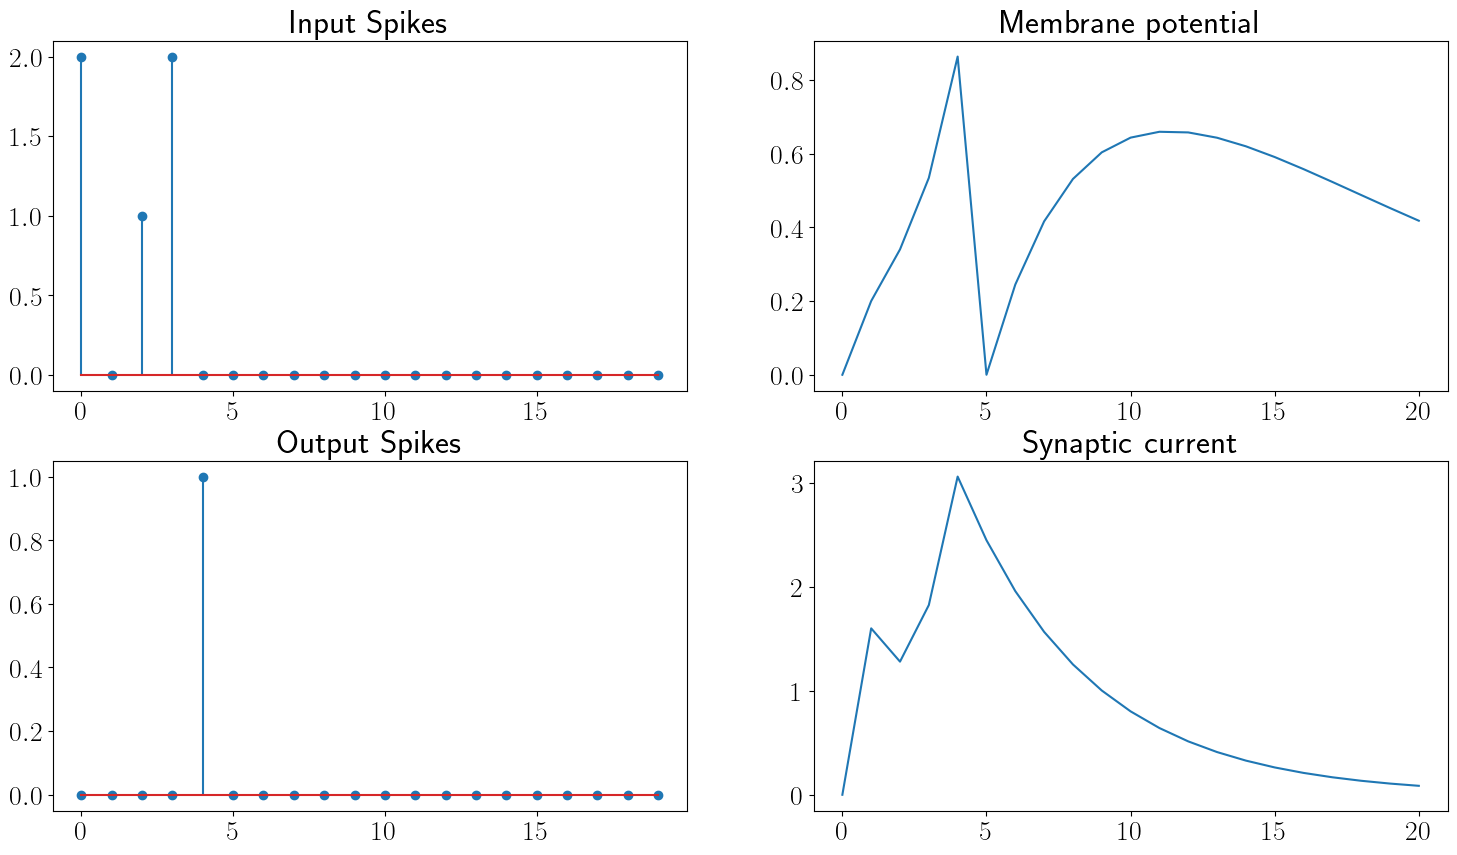

In [5]:
input_spikes    = torch.zeros((20,1),device=device)

#Define input spikes and their amplitude here
input_spikes[0] = 2
input_spikes[1] = 0
input_spikes[2] = 1
input_spikes[3] = 2

output_spikes    = torch.zeros((20,1),device=device)
v               = torch.zeros((21,1),device=device)
i               = torch.zeros((21,1),device=device)

#Adjust the membrane and synaptic time constant here
tau_mem = 10e-3
tau_syn = 5e-3

for ts in range(output_spikes.shape[0]):
    output_spikes[ts], v[ts+1], i[ts+1] = LIF(input_spikes[ts],v[ts],i[ts],1/tau_mem,1/tau_syn,dt=1e-3)


plt.figure()

plt.subplot(221)
plt.stem(input_spikes.detach().cpu().numpy())
plt.title("Input Spikes")

plt.subplot(223)
plt.stem(output_spikes.detach().cpu().numpy())
plt.title("Output Spikes")

plt.subplot(222)
plt.plot(v.detach().cpu().numpy())
plt.title("Membrane potential")

plt.subplot(224)
plt.plot(i.detach().cpu().numpy())
plt.title("Synaptic current")


## Direct firing
For this paper, the memory of the LIF neuron is deactivated. This corresponds to a LIF neuron with a very low time constant.
Hence, if this system would be implemented on neuromorphic hardware one would need fast firing neurons compated to time intervalls between the inputs and perfectly in time synchronized input values.

Text(0.5, 1.0, 'Synaptic current')

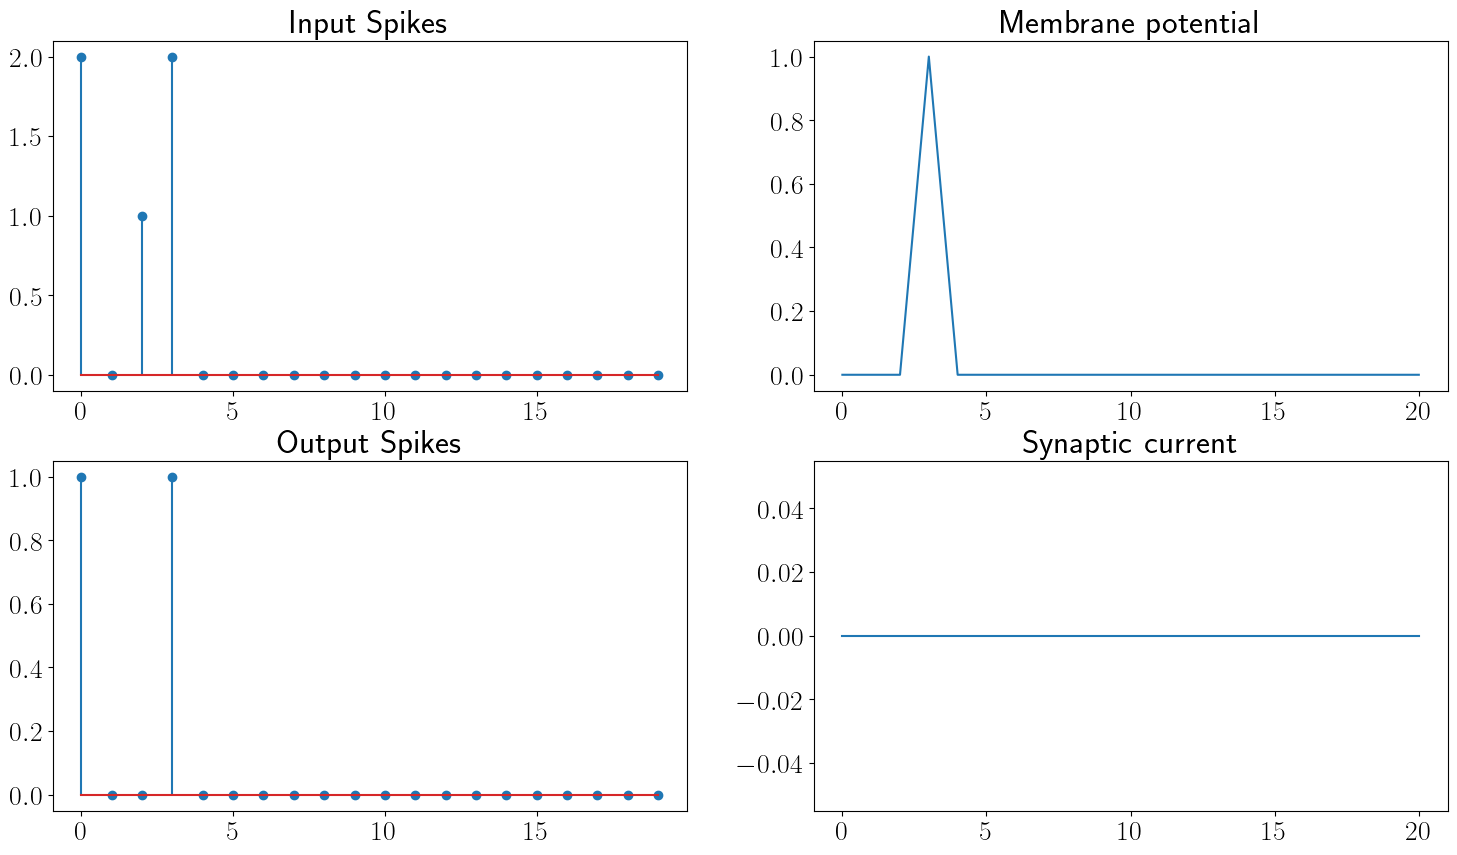

In [6]:
input_spikes    = torch.zeros((20,1),device=device)

#Define input spikes and their amplitude here
input_spikes[0] = 2
input_spikes[1] = 0
input_spikes[2] = 1
input_spikes[3] = 2

output_spikes    = torch.zeros((20,1),device=device)
v               = torch.zeros((21,1),device=device)
i               = torch.zeros((21,1),device=device)

#Adjust the membrane and synaptic time constant here
tau_mem = 1e-3
tau_syn = 1e-3

for ts in range(output_spikes.shape[0]):
    output_spikes[ts], v[ts+1], i[ts+1] = LIF(input_spikes[ts],v[ts],i[ts],1/tau_mem,1/tau_syn,dt=1e-3)


plt.figure()

plt.subplot(221)
plt.stem(input_spikes.detach().cpu().numpy())
plt.title("Input Spikes")

plt.subplot(223)
plt.stem(output_spikes.detach().cpu().numpy())
plt.title("Output Spikes")

plt.subplot(222)
plt.plot(v.detach().cpu().numpy())
plt.title("Membrane potential")

plt.subplot(224)
plt.plot(i.detach().cpu().numpy())
plt.title("Synaptic current")


## Definition of the ML-ELENA Decoder 
This code creates the "wiring", the distribution of the messages to the corresponding VN-Update node. and to the corresponding CN-Update nodes.
Afterwards the ML-Elena Decoder is defined.

In [7]:
##############################################################
# This function creates the indices corresponding to the
# variable and check nodes, with the indices a sparse matrix
# multiplication of binary matrices is implemented by slicing 
def make_SNN(H):
    #Transform Parity Check Matrix to integer
    H = H.astype(int)
    #Calculate maximum check node degree
    d_c_max = np.max(np.sum(H,axis=1))

    #Create index matrix, each nonzero element in H gets ascending number
    idx = np.zeros_like(H)
    idx[np.nonzero(H)] = np.cumsum(H[np.nonzero(H)])
    #For regular LDPC codes d_c_max is constant, thus create matrix for checknode input indices
    cn_idx = np.zeros((np.sum(H),d_c_max-1))
    #Loop over SPC
    for n in range(H.shape[0]):
        #Each row of H creates d_c_max-1 checks
        for k in range(d_c_max):
            #Input all indices except the k-th one (extrinsic message)
            cn_idx[n*d_c_max+k] = idx[n][np.delete(np.nonzero(H[n])[0],k)]
    #Convert counting from 1,...,N to 0,...,N-1 for indexing
    cn_idx -= 1

    #Create 2D lists, inputs to variable nodes from check nodes and input to variable nodes from channel input values
    vn_idx = [[]]
    llr_idx = [[]]
    for n in range(np.sum(H)-1):
        vn_idx.append([])
        llr_idx.append([])

    #Create 1D list for variable node messages to output
    out_idx = []

    #Transpose indices
    idx = idx.T
    #Loop over colums
    for n in range(H.shape[1]):
        nz = np.nonzero(idx[n])[0]
        #All nonzero elements in column define "n-th" output bit
        out_idx.append((idx[n][nz]-1).tolist())
        for k in range(len(nz)):
            #Exclude "k-th" message (extrinsic message)
            vn_idx[(idx[n][nz[k]]-1)] = (idx[n][np.delete(nz,k)]-1).tolist()
            #All nonzero elements in column need "n-th" channel input value
            llr_idx[(idx[n][nz[k]]-1)].append(n)

    return cn_idx, vn_idx, llr_idx, out_idx

class SNN_Decoder(nn.Module):
    def __init__(self, N, H, device, dt=0.001):
        super(SNN_Decoder, self).__init__()
        self.device = device;

        self.N               =  N

        self.H               = H

        self.dt              = dt

        self.d_v     = np.max(np.sum(self.H,axis=0)).astype(int)
        self.d_c     = np.max(np.sum(self.H,axis=1)).astype(int)
        self.No_messages = np.sum(self.H).astype(int) 
        
        #############################################################################################################################################
        # SNN Weights and Biases                                                                                                                    #
        #############################################################################################################################################
        #Indices of the messages beloning to the corresponding SPC unit
        cn_idx, vn_idx, llr_idx, out_idx = make_SNN(H)

        self.checknode_indices      = cn_idx
        self.varnode_input_messages = vn_idx
        self.varnode_input_LLR      = llr_idx
        self.varnode_to_LLR         = out_idx

        #Bias (Theta 1) / Amplitude (Theta_2) [Actual parameters that are tuned.
        self.th_bias = 1.2
        self.amp     = 1.2

        #Not needed since no gradient descend is used
        self.alpha = 100

        #Number of parallel ELENA Units per SCNU
        self.LEVELS = 15

        #Memory is deactivated
        self.tau_mem_inv_LIF = 1000
        self.tau_syn_inv_LIF = 1000

        #This amplification ensures LIF neurons to fire
        self.LIFAMP = 10


    def forward(self, x):
        #Define how may iterations the BP will run
        seq_length=20

        #Get the batch size
        batch_size,_ = x.shape

        #Output value buffer
        out           = torch.zeros(seq_length,x.shape[0], self.N, device=self.device)
        #Number of hidden spikes get accumulated here
        hidden_spikes = 0

        threshold_spikes = torch.zeros( (seq_length,x.shape[0],self.No_messages*self.LEVELS), device=self.device)
        deactivation_spikes = torch.zeros( (seq_length,x.shape[0],self.No_messages*self.LEVELS), device=self.device)
        
        #Buffer for feed back of the Checknode Messages to the Variable Nodes
        z_rec = torch.zeros( (seq_length+1,x.shape[0],self.No_messages), device=self.device)    
        
        #Iterate BP
        v1 = torch.zeros((self.LEVELS,x.shape[0],self.No_messages),device=self.device)
        i1 = torch.zeros((self.LEVELS,x.shape[0],self.No_messages),device=self.device)
        rho1 = torch.zeros((self.LEVELS,x.shape[0],self.No_messages),device=self.device)
        v2 = torch.zeros((self.LEVELS,x.shape[0],self.No_messages,1),device=self.device)
        i2 = torch.zeros((self.LEVELS,x.shape[0],self.No_messages,1),device=self.device)
        rho2 = torch.zeros((self.LEVELS,x.shape[0],self.No_messages,1),device=self.device)

        v3 = 0
        i3 = 0
        for ts in range(seq_length):
            # Output: (Batchsize , No. Messages)
            # Input LLR to corresponding "1" entries in parity check matrix ("Wireing")
            z = x[::,self.varnode_input_LLR].flatten(-2)
            
            z += torch.sum(z_rec[ts,::,self.varnode_input_messages],axis=2)#("Wireing")

            ###########################################################################################################################################################
            # Take Signs of Messages
            signs = torch.sign(z)

            # Select corresponding VN messages for CN update Output: (Batchsize, No. Messages, dv - 1) ("Wireing")
            signs = signs[::,self.checknode_indices]
            z_t = 0
            for step in range(self.LEVELS):
                # Comparator checks if absolute of message is beyond threshold
                ################################################################################################
                #If absolute values are below threshold, LIF neuron is charged and forced to fire
                z_i = -self.LIFAMP*(torch.abs(z)-self.th_bias*(step+1))
                z_i,v_buff,i_buff = LIF(z_i,v1[step],i1[step],self.tau_mem_inv_LIF,self.tau_syn_inv_LIF,dt=1e-3)
                v1[step] = v_buff
                i1[step] = i_buff
                threshold_spikes[ts,::,self.No_messages*step:self.No_messages*(step+1)] = z_i
                
                ################################################################################################
                hidden_spikes += torch.sum(z_i)

                # Select corresponding VN messages for CN update Output: (Batchsize, No. Messages, dv - 1) ("Wireing")
                z_i = z_i[::,self.checknode_indices]
                
                #OR (If any of the incoming d_c lines has a spike, the LIF neuron emits a spike)
                ################################################################################################
                z_i,v_buff,i_buff = LIF(self.LIFAMP*torch.sum(z_i ,axis=2,keepdim=True),v2[step],i2[step],self.tau_mem_inv_LIF,self.tau_syn_inv_LIF,dt=1e-3)
                v2[step] = v_buff
                i2[step] = i_buff
                deactivation_spikes[ts,::,self.No_messages*step:self.No_messages*(step+1)] = z_i.flatten(-2)

                ################################################################################################
                hidden_spikes += torch.sum(z_i)

                #Scale with amplitude (Theta_2) (If any OR LIF neuron emits a spike, the amplitude of the message is not increased, otherwise increase by Theta_2)
                z_t += self.amp * (1-z_i)

            ################################################################################################################################################################
            
            #Multiply Signs (XOR)
            signs = torch.prod(signs,axis=2,keepdim=True)            
            #Multipy signs and abs (Append sign bit to abs bits)
            z = z_t*signs
            z = z.flatten(-2)

            ###########################################################################################

            #Send Messages to the Variable Nodes
            z_rec[ts+1,::,::] = z.clone()

            #Calcuate the output LLRs
            out[ts] = torch.sum(z_rec[ts,::,self.varnode_to_LLR],axis=2)
            out[ts] = out[ts]+x

        del z
        del z_t, z_i
        del signs
        del z_rec

        #Spikerate = Number of Spikes emitted / (Number of parallel computed Codewords * Number of Iterations* 2 * No of Ones in H * Number of Parallel ELENA Decoders per SCNU)
        spikerate = hidden_spikes/(batch_size*seq_length*2*self.No_messages*self.LEVELS)

        return out, spikerate, threshold_spikes, deactivation_spikes
        

In [8]:
#Get current path
notebook_path = os.path.abspath("Notebook.ipynb")
Decode_alist = os.path.join(os.path.dirname(notebook_path), "LDPC_3_15_n38400.alist")

#Read .alist file to get Parity Check matrix
H = read_alist_file(Decode_alist).toarray();

N = H.shape[1]

#Create Elena-SNN
decoder = SNN_Decoder(N, H, device, dt=0.001)
decoder.to(device)


SNN_Decoder()

Let us calculate an example:

In [9]:
bits = torch.zeros((1,38400),device=device);                #Zero codeword
x      = -2*(bits-0.5)                                      # Cast 1 to -1 and 0 to 1                    #BPSK

esn0_dB = 3.1                                               #Convert Eb/N0 to Es/N0
sigma = np.sqrt( 0.5*(10**(-esn0_dB / 10)) );                                #Calculate sigma
noise = torch.randn(x.shape,device=device);                                  #Create noise
noise = sigma * noise;                                                       #Scale noise to correct SNR
y = x + noise                                                                #Apply noise
y = 4*10**(esn0_dB/10) * y                                                  # Channel output to LLR

out, sr, threshold_spikes, deactivation_spikes = decoder(y)

## Encoding
The received codeword has to be mapped to a spatio temporal sequence, such that the SNN can process the input.
In this paper, the codeword is just repeated 20 times, corresponding to 20 BP iterations.
This is not a binary spike encoding, it's a graded spike encoding, the spikes are real valued.

torch.Size([1, 38400])
torch.Size([20, 30])


Text(0.5, 0, 'Input')

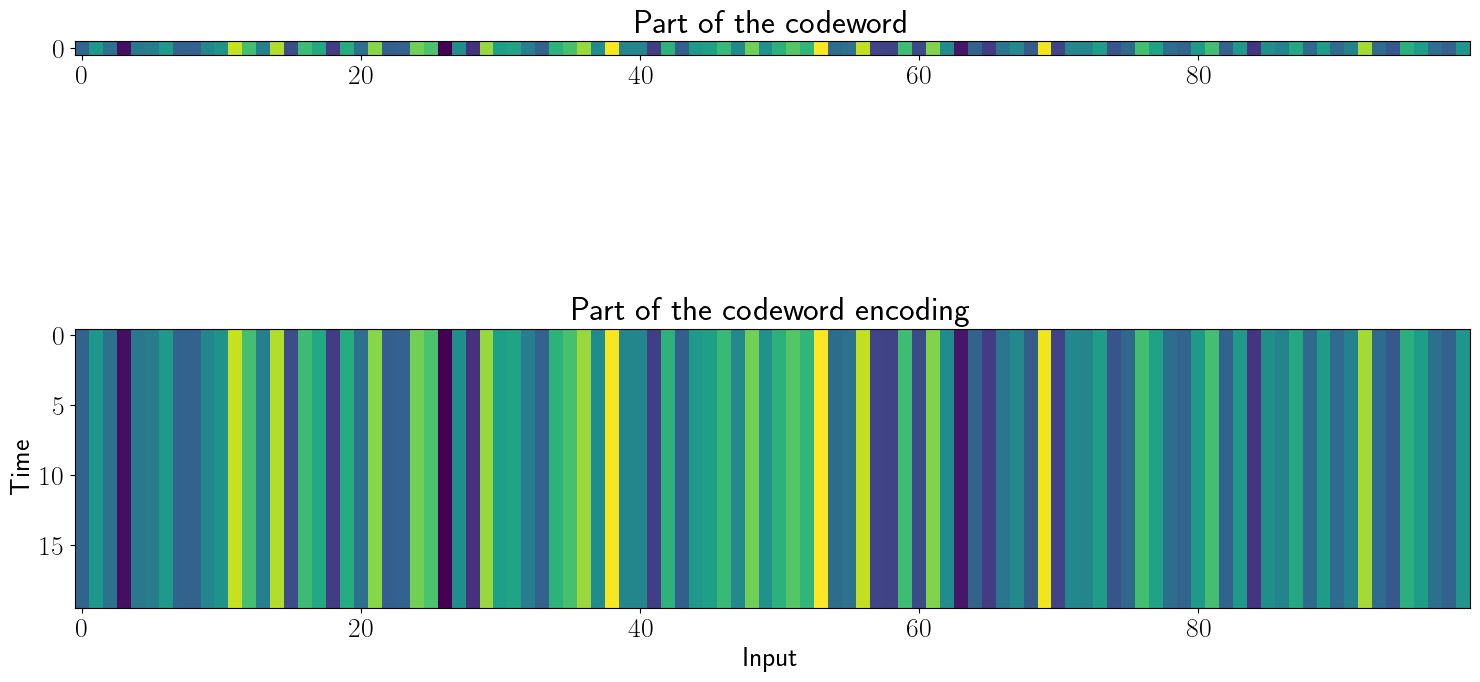

In [10]:
print(y.shape)
print(y[0, 0: 30:].repeat(20,1).shape)

plt.subplot(211)
plt.imshow(y[::, 0: 100:])
plt.title("Part of the codeword")
plt.yticks([0])

plt.subplot(212)
plt.imshow(y[::, 0: 100:].repeat(20,1))
plt.title("Part of the codeword encoding")
plt.ylabel("Time")
plt.xlabel("Input")


## Threshold spikes
The plot shows a fraction of the threshold spikes.
If a message is below one of the 15 thresholds, the corresponding LIF neuron will emit a spike.
The plot shows, that the messages are below the lowest threshold only in the first two iterations.
The highest threshold fires the longest, however, even this threshold is surpassed after 5-6 iterations.

Text(0.5, -9.87865329234119, 'Input')

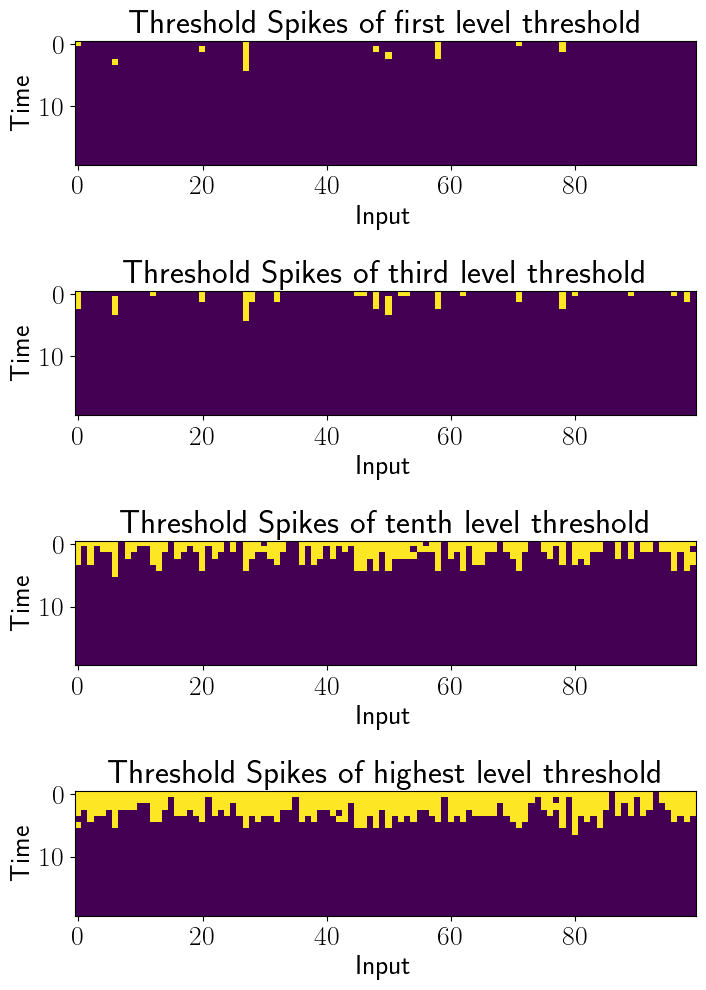

In [11]:
plt.figure()

plt.subplot(411)
plt.imshow(threshold_spikes[::,0, 1*decoder.No_messages: 1*decoder.No_messages+100:])
plt.title("Threshold Spikes of first level threshold")
plt.tight_layout()
plt.ylabel("Time")
plt.xlabel("Input")

plt.subplot(412)
plt.imshow(threshold_spikes[::,0, 3*decoder.No_messages: 3*decoder.No_messages+100:])
plt.title("Threshold Spikes of third level threshold")
plt.tight_layout()
plt.ylabel("Time")
plt.xlabel("Input")

plt.subplot(413)
plt.imshow(threshold_spikes[::,0,10*decoder.No_messages:10*decoder.No_messages+100:])
plt.title("Threshold Spikes of tenth level threshold")
plt.tight_layout()
plt.ylabel("Time")
plt.xlabel("Input")

plt.subplot(414)
plt.imshow(threshold_spikes[::,0,14*decoder.No_messages:14*decoder.No_messages+100:])
plt.title("Threshold Spikes of highest level threshold")
plt.tight_layout()
plt.ylabel("Time")
plt.xlabel("Input")


## Deactivation Spikes
The threshold spikes are distributed to the corresponding SCNUs by the "wireing" (which is defined by the parity check matrix).
If any on any of the $d_c-1$ input lines a spike is transmitted to the LIF neuron, the LIF neuron fires and deactivates the output.
The transmitted message it thus not increased by Theta_2.

Text(0.5, -9.87865329234119, 'Input')

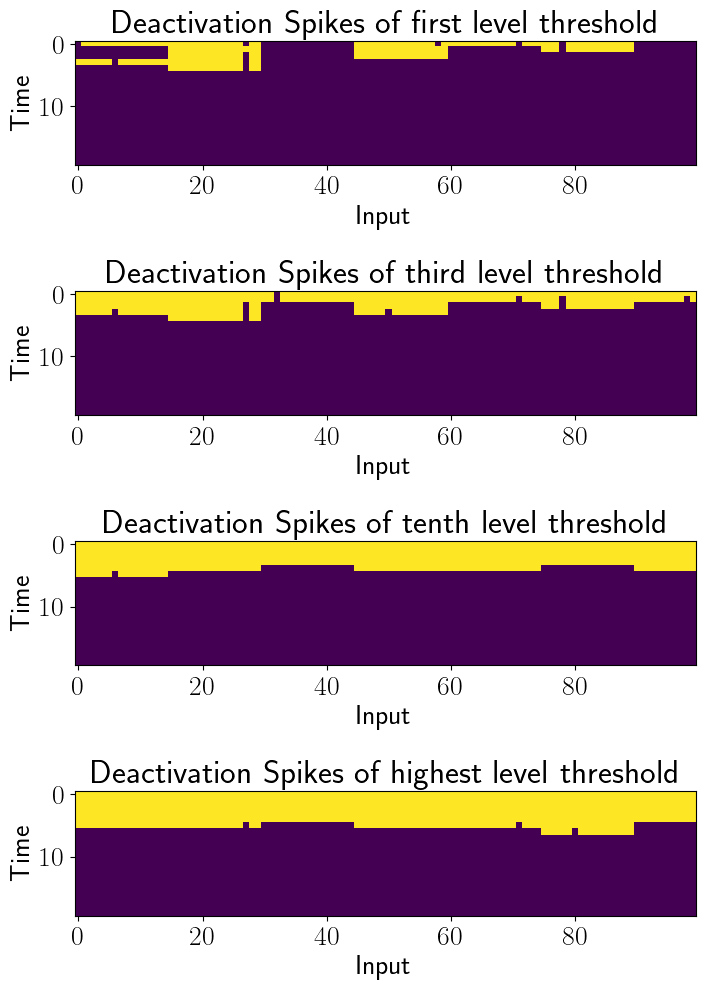

In [12]:
plt.figure()

plt.subplot(411)
plt.imshow(deactivation_spikes[::,0, 1*decoder.No_messages: 1*decoder.No_messages+100:])
plt.title("Deactivation Spikes of first level threshold")
plt.tight_layout()
plt.ylabel("Time")
plt.xlabel("Input")

plt.subplot(412)
plt.imshow(deactivation_spikes[::,0, 3*decoder.No_messages: 3*decoder.No_messages+100:])
plt.title("Deactivation Spikes of third level threshold")
plt.tight_layout()
plt.ylabel("Time")
plt.xlabel("Input")

plt.subplot(413)
plt.imshow(deactivation_spikes[::,0,10*decoder.No_messages:10*decoder.No_messages+100:])
plt.title("Deactivation Spikes of tenth level threshold")
plt.tight_layout()
plt.ylabel("Time")
plt.xlabel("Input")

plt.subplot(414)
plt.imshow(deactivation_spikes[::,0,14*decoder.No_messages:14*decoder.No_messages+100:])
plt.title("Deactivation Spikes of highest level threshold")
plt.tight_layout()
plt.ylabel("Time")
plt.xlabel("Input")

## SCNU Dynamic Range
Due to the several parallel ELENA units, the SCNU has an increased dynamic range

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


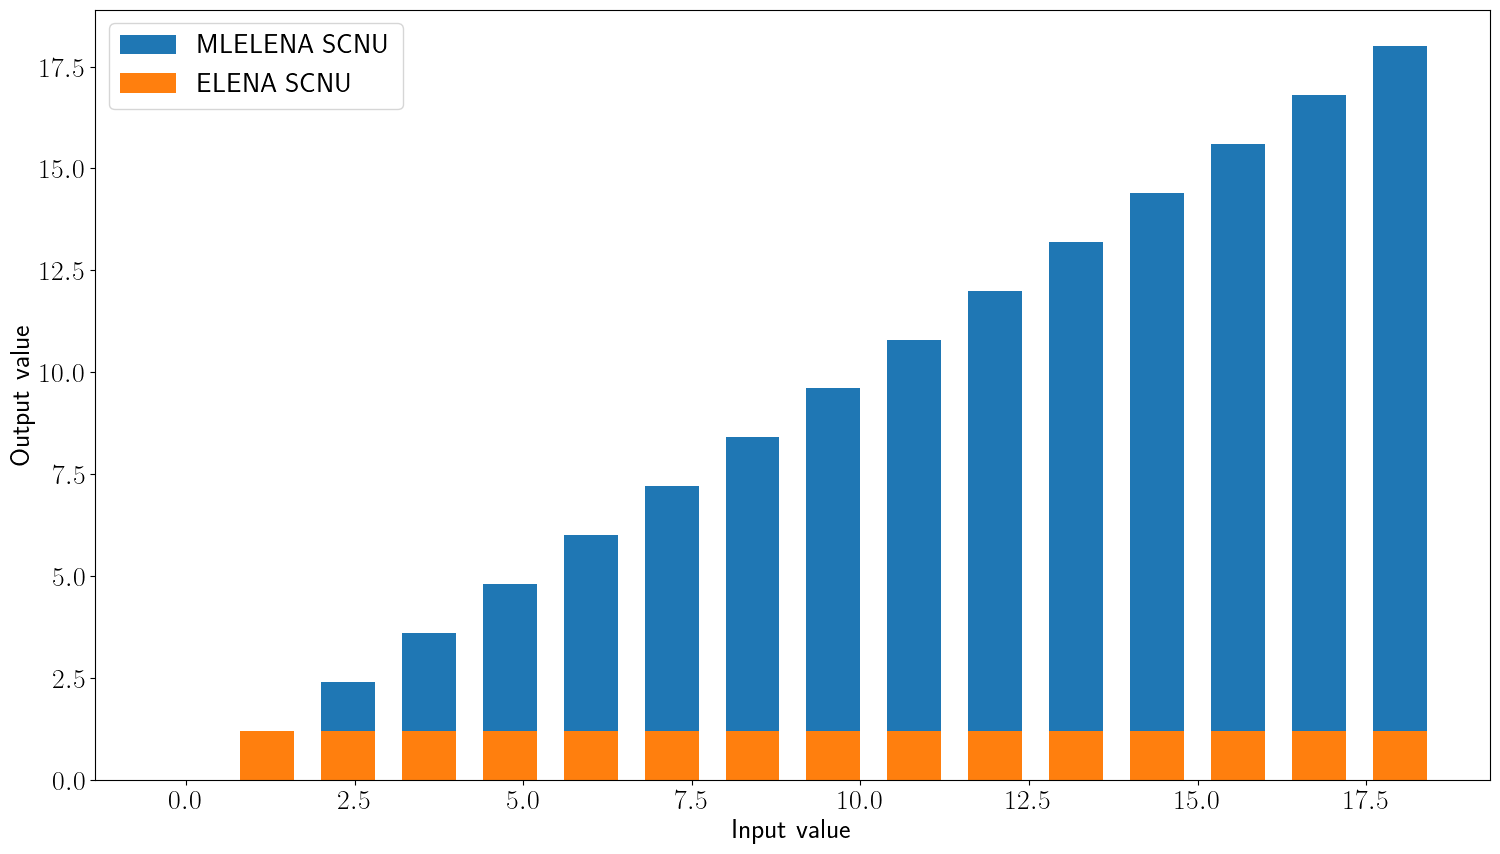

In [13]:
x = np.linspace(0,15,16)
print(x)

plt.figure()
plt.bar(x*decoder.th_bias,decoder.amp*x,label='MLELENA SCNU')
plt.bar(x*decoder.th_bias,decoder.amp*np.where(x>0,1,0),label='ELENA SCNU')
plt.xlabel("Input value")
plt.ylabel("Output value")
plt.legend()


In [14]:
#Define Eb/N0 values to simulate 
EBN0_dB = np.arange(2.5,4.0,0.1)

#Channel reliability Es/N0 that is used throughout the simulation
op_point = 3.1

#Epochs
EPOCHS = 5

#Number of codewords
CW = 40

#Keep this fixed since we use a (38400,30720) Regular LDPC code
N = 38400
K = 30720
rate = K/N

ERRORS   = np.zeros(EBN0_dB.shape)
F_ERRORS = np.zeros(EBN0_dB.shape)
BER      = np.zeros(EBN0_dB.shape)
FER      = np.zeros(EBN0_dB.shape)

for idx_P, snr_i in enumerate(EBN0_dB):
    print("EBN0: "+str(snr_i))
    for epoch_cnt in range(EPOCHS):
        bits = torch.zeros((CW,N),device=device);                                    #Zero codeword
        x      = -2*(bits-0.5)          # Cast 1 to -1 and 0 to 1                    #BPSK

        esn0_dB = snr_i + 10 * np.log10( rate )                                      #Convert Eb/N0 to Es/N0
        sigma = np.sqrt( 0.5*(10**(-esn0_dB / 10)) );                                #Calculate sigma
        noise = torch.randn(x.shape,device=device);                                  #Create noise
        noise = sigma * noise;                                                       #Scale noise to correct SNR
        y = x + noise                                                                #Apply noise
        
        y = 4*10**(op_point/10) * y                                                  # Channel output to LLR

        outputs, SR, _, _ = decoder(y)                                                  #Apply Elena-SNN

        recv_bits = torch.where(sigmoid(-1*outputs[-1,::,::])>=0.5,1,0)                        #Hard decision
        ERRORS[idx_P] += torch.sum(torch.abs(recv_bits-bits)).detach().cpu().numpy() #Calculate bit errors
        F_ERRORS[idx_P] += torch.sum(torch.where(torch.sum(torch.abs(recv_bits-bits),axis=1)>0,1,0)).detach().cpu().numpy() #Calculate frame errors
    print(ERRORS[idx_P] / (N*CW*EPOCHS))
    print(SR)
    
BER = ERRORS / (N*CW*EPOCHS)                                                         #Calculate BER
FER = F_ERRORS / (CW*EPOCHS)                                                         #Calculate FER

EBN0: 2.5
0.027886067708333333
tensor(0.6889)
EBN0: 2.6
0.022396614583333332
tensor(0.6773)
EBN0: 2.7
0.014772526041666666
tensor(0.6534)
EBN0: 2.8000000000000003
0.005904036458333334
tensor(0.6027)
EBN0: 2.9000000000000004
0.00043828125
tensor(0.4783)
EBN0: 3.0000000000000004
5.208333333333334e-07
tensor(0.3845)
EBN0: 3.1000000000000005
0.0
tensor(0.3182)
EBN0: 3.2000000000000006
0.0
tensor(0.2731)
EBN0: 3.3000000000000007
0.0
tensor(0.2421)
EBN0: 3.400000000000001
0.0
tensor(0.2184)
EBN0: 3.500000000000001
0.0
tensor(0.2052)
EBN0: 3.600000000000001
0.0
tensor(0.1873)
EBN0: 3.700000000000001
0.0
tensor(0.1748)
EBN0: 3.800000000000001
0.0
tensor(0.1631)
EBN0: 3.9000000000000012
0.0
tensor(0.1527)


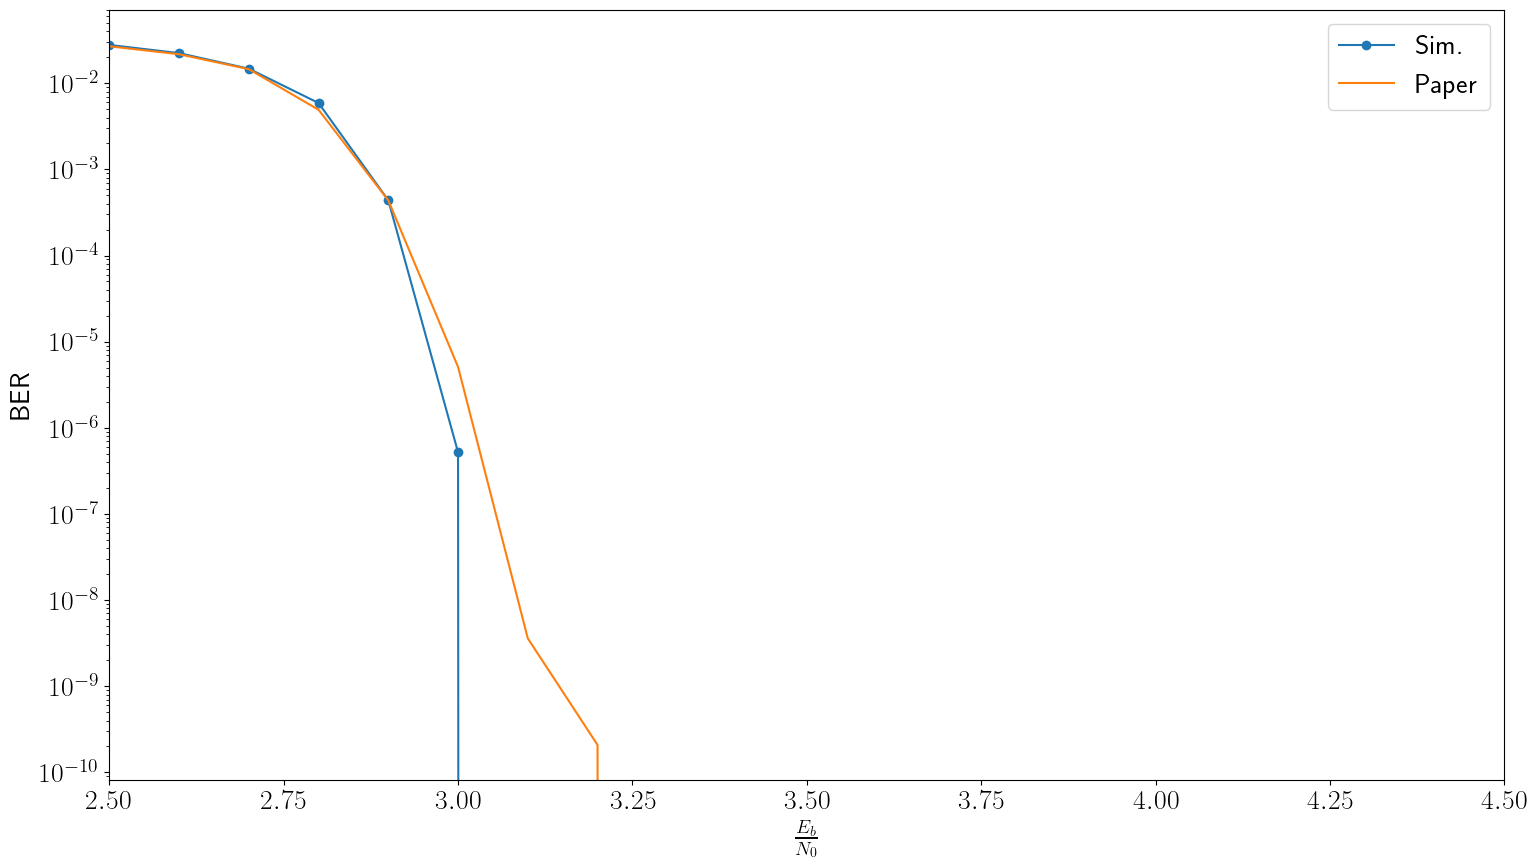

In [15]:
Paper_EBN0_dB = np.arange(2.5,4.0,0.1)
Paper_BER = np.array(  [2.68768646e-02, 2.17491927e-02, 1.45787813e-02, 4.93048438e-03,
                        4.37187500e-04, 5.09614583e-06, 3.59375000e-09, 2.08333333e-10,
                        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                        0.00000000e+00, 0.00000000e+00, 0.00000000e+00] )

plt.figure()
plt.semilogy(EBN0_dB,BER,label='Sim.',marker='o')
plt.semilogy(Paper_EBN0_dB,Paper_BER,label='Paper')
plt.xlim(2.5,4.5)
#plt.ylim(5e-8,0.2)
plt.xlabel("$\\frac{E_b}{N_0}$")
plt.ylabel("BER")
plt.legend()